In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
# gravity constant
g = 9.8066
# participants number
pNum = 67
# window size = 1000 lines from the dataset
# given the sampling rate of the Mobiact, the time period of this rougly 5s
wSize = 1000
# overlap rate between window is 0.8 
# i.e. in the case setting windows size = 5s, the interval between windows is 1s 
overlapRate = 0.8
# two dictionary represents the ADLs (Activities of daily living) & Fall event
# the key is the acronym of ADLs, the value is the numbers of trials
# Activities of Daily Living:
# +----+-------+----------------------------+--------+----------+---------------------------------------------------+
# | No.| Label | Activity                   | Trials | Duration | Description                                       |
# +----+-------+----------------------------+--------+----------+---------------------------------------------------+
# | 1  | STD   | Standing                   | 1      | 5min     | Standing with subtle movements                    |
# | 2  | WAL   | Walking                    | 1      | 5min     | Normal walking                                    |
# | 3  | JOG   | Jogging                    | 3      | 30s      | Jogging                                           |
# | 4  | JUM   | Jumping                    | 3      | 30s      | Continuous jumping                                |
# | 5  | STU   | Stairs up                  | 6      | 10s      | Stairs up (10 stairs)                             |
# | 6  | STN   | Stairs down                | 6      | 10s      | Stairs down (10 stairs)                           |
# | 7  | SCH   | Stand to sit(sit on chair) | 6      | 6s       | Transition from standing to sitting               |
# | 8  | SIT   | Sitting on chair           | 1      | 1min     | Sitting on a chair with subtle movements          |
# | 9  | CHU   | Sit to stand(chair up)     | 6      | 6s       | Transition from sitting to standing               |
# | 10 | CSI   | Car-step in                | 6      | 6s       | Step in a car                                     |
# | 11 | CSO   | Car-step out               | 6      | 6s       | Step out a car                                    |
# | 12 | LYI   | Lying                      | 12     | -        | Activity taken from the lying period after a fall |
# +----+-------+----------------------------+--------+----------+---------------------------------------------------+

# Falls:
# +----+-------+--------------------+--------+----------+---------------------------------------------------------+
# | No.| Label | Activity           | Trials | Duration | Description                                             |
# +----+-------+--------------------+--------+----------+---------------------------------------------------------+
# | 10 | FOL   | Forward-lying      | 3      | 10s      | Fall Forward from standing, use of hands to dampen fall |
# | 11 | FKL   | Front-knees-lying  | 3      | 10s      | Fall forward from standing, first impact on knees       |
# | 12 | BSC   | Back-sitting-chair | 3      | 10s      | Fall backward while trying to sit on a chair            |
# | 13 | SDL   | Sideward-lying     | 3      | 10s      | Fall sidewards from standing, bending legs              |
# +----+-------+--------------------+--------+----------+---------------------------------------------------------+
ADLs = {'STD':1,'WAL':1,'JOG':3,'JUM':3,'STU':6,'STN':6,'SCH':6,'SIT':1,'CHU':3,"CSI":3,'CSO':3,'LYI':0}
Falls = {'FOL':3,'FKL':3,'BSC':3,'SDL':3}
Events = ['STD','WAL','JOG','JUM','STU','STN','SCH','SIT','CHU',"CSI",'CSO','LYI','FOL','FKL','BSC','SDL']

In [63]:
# return the signal matitude vector (norm of the composition vector of 3-axis accleration)
def SMV(accX:float, accY:float, accZ:float)->float:
    return math.sqrt(pow(accX,2)+pow(accY,2)+pow(accZ,2))

# used for observation
def testSMV(eventName:str, pId:str, trialNum:str):
    fileName = eventName + '\\{}_{}_{}_annotated.csv'.format(eventName,pId,trialNum)
    filePath = os.path.join(os.getcwd(), 'MobiAct_Dataset_v2.0\Annotated Data', fileName)
    data = pd.read_csv(filePath)
    cols = ['rel_time','acc_x','acc_y','acc_z','label']
    data = data[cols]
    for line in range(0, len(data) - 1):
        accX = data['acc_x'][line]
        accY = data['acc_y'][line]
        accZ = data['acc_z'][line]
        label = data['label'][line]
        print('{}, smv = {}\tlabel = {} '.format(line + 1, SMV(accX, accY, accZ), label))

# testSMV('BSC','1','1')

In [64]:
def convertToWindows(mainEvent: str, rawData:pd.DataFrame)->pd.DataFrame:
    numLines = len(rawData)
    max_smv = float('inf')
    min_smv = 0
    intervalFrames = wSize * (1 - overlapRate)
    numOfWindows = math.ceil((numLines - wSize) / intervalFrames) + 1
    featureCols = ['acc_x','acc_y','acc_z','label']
    featureData = rawData[featureCols]
    featureData.loc[:,'smv'] = ''
    for line in range(0, len(featureData)):
        accX = featureData['acc_x'][line]
        accY = featureData['acc_y'][line]
        accZ = featureData['acc_z'][line]
        featureData.loc[line,'smv'] = SMV(accX, accY, accZ)
    featureData = featureData.drop(['acc_x','acc_y','acc_z'],axis=1)
    featureData = featureData[['smv','label']]
    isFall = False
    if mainEvent in Falls.keys():
        fallEventIdx = featureData.index[featureData['label'] == mainEvent]
        startFrame = fallEventIdx[0]
        endFrame = fallEventIdx[-1]
        isFall = True
    windows = pd.DataFrame(columns=['max_smv','min_smv','label'])
    for idx in range(0,numOfWindows):
        startOfWindow = idx * intervalFrames 
        endOfWindow = idx * intervalFrames + wSize - 1
        if endOfWindow > numLines:
            endOfWindow = numLines
        window = featureData.loc[startOfWindow : endOfWindow,:]
        winSmv = window['smv']
        maxSmv = winSmv.max()
        minSmv = winSmv.min()
        if not isFall:
            winLabel = 0
        else:
            if startOfWindow <= startFrame and endOfWindow >= endFrame:
                winLabel = 1
            else:
                winLabel = 0
        newWindow = pd.DataFrame([[maxSmv,minSmv,winLabel]],columns=['max_smv','min_smv','label'])
        windows = pd.concat([windows,newWindow],ignore_index=True)
    return windows


In [74]:
# Load data
import random
trnSet = pd.DataFrame(columns=['max_smv','min_smv','label'])
tstSet = pd.DataFrame(columns=['max_smv','min_smv','label'])
for event in Events:
    if event in ADLs.keys():
        trialTimes = ADLs.get(event)
    else:
        trialTimes = Falls.get(event)
    for i in range(1, pNum + 1):
        for j in range(1, trialTimes + 1):
            fileName = event + '\\{}_{}_{}_annotated.csv'.format(event,i,j)
            print(fileName)
            dataPath = os.path.join(os.getcwd(), 'MobiAct_Dataset_v2.0\Annotated Data', fileName)
            try:
                rawData = pd.read_csv(dataPath)
                if trialTimes == 1:
                    rdm =  random.randint(1,3)
                    if rdm == 1 or rdm == 2:
                        trnSet = pd.concat([trnSet, convertToWindows(event, rawData)], ignore_index=True)
                    if rdm == 3:
                        tstSet = pd.concat([tstSet, convertToWindows(event, rawData)], ignore_index=True)                
                if trialTimes == 3:
                    if j == 1 or j == 2:
                        trnSet = pd.concat([trnSet, convertToWindows(event, rawData)], ignore_index=True)
                    if j == 3:
                        tstSet = pd.concat([tstSet, convertToWindows(event, rawData)], ignore_index=True)
                if trialTimes == 6:
                    if j >= 1 and j <= 4:
                        trnSet = pd.concat([trnSet, convertToWindows(event, rawData)], ignore_index=True)
                    if j > 4:
                        tstSet = pd.concat([tstSet, convertToWindows(event, rawData)], ignore_index=True)
            except FileNotFoundError:
                print('{} is not found'.format(fileName))
            continue
trnSet.to_csv('trnSet.csv',index=False)
tstSet.to_csv('tstSet.csv',index=False)

STD\STD_1_1_annotated.csv
STD\STD_2_1_annotated.csv
STD\STD_3_1_annotated.csv
STD\STD_4_1_annotated.csv
STD\STD_5_1_annotated.csv
STD\STD_6_1_annotated.csv
STD\STD_7_1_annotated.csv
STD\STD_8_1_annotated.csv
STD\STD_9_1_annotated.csv
STD\STD_10_1_annotated.csv
STD\STD_11_1_annotated.csv
STD\STD_12_1_annotated.csv
STD\STD_13_1_annotated.csv
STD\STD_13_1_annotated.csv is not found
STD\STD_14_1_annotated.csv
STD\STD_14_1_annotated.csv is not found
STD\STD_15_1_annotated.csv
STD\STD_15_1_annotated.csv is not found
STD\STD_16_1_annotated.csv
STD\STD_17_1_annotated.csv
STD\STD_17_1_annotated.csv is not found
STD\STD_18_1_annotated.csv
STD\STD_19_1_annotated.csv
STD\STD_20_1_annotated.csv
STD\STD_21_1_annotated.csv
STD\STD_22_1_annotated.csv
STD\STD_23_1_annotated.csv
STD\STD_24_1_annotated.csv
STD\STD_25_1_annotated.csv
STD\STD_26_1_annotated.csv
STD\STD_27_1_annotated.csv
STD\STD_28_1_annotated.csv
STD\STD_29_1_annotated.csv
STD\STD_30_1_annotated.csv
STD\STD_30_1_annotated.csv is not found

JOG\JOG_43_1_annotated.csv
JOG\JOG_43_2_annotated.csv
JOG\JOG_43_3_annotated.csv
JOG\JOG_44_1_annotated.csv
JOG\JOG_44_2_annotated.csv
JOG\JOG_44_3_annotated.csv
JOG\JOG_45_1_annotated.csv
JOG\JOG_45_2_annotated.csv
JOG\JOG_45_3_annotated.csv
JOG\JOG_46_1_annotated.csv
JOG\JOG_46_2_annotated.csv
JOG\JOG_46_3_annotated.csv
JOG\JOG_47_1_annotated.csv
JOG\JOG_47_2_annotated.csv
JOG\JOG_47_3_annotated.csv
JOG\JOG_48_1_annotated.csv
JOG\JOG_48_2_annotated.csv
JOG\JOG_48_3_annotated.csv
JOG\JOG_49_1_annotated.csv
JOG\JOG_49_2_annotated.csv
JOG\JOG_49_3_annotated.csv
JOG\JOG_50_1_annotated.csv
JOG\JOG_50_2_annotated.csv
JOG\JOG_50_3_annotated.csv
JOG\JOG_51_1_annotated.csv
JOG\JOG_51_2_annotated.csv
JOG\JOG_51_3_annotated.csv
JOG\JOG_52_1_annotated.csv
JOG\JOG_52_2_annotated.csv
JOG\JOG_52_3_annotated.csv
JOG\JOG_53_1_annotated.csv
JOG\JOG_53_2_annotated.csv
JOG\JOG_53_3_annotated.csv
JOG\JOG_54_1_annotated.csv
JOG\JOG_54_2_annotated.csv
JOG\JOG_54_3_annotated.csv
JOG\JOG_55_1_annotated.csv
J

STU\STU_1_3_annotated.csv
STU\STU_1_4_annotated.csv
STU\STU_1_5_annotated.csv
STU\STU_1_6_annotated.csv
STU\STU_2_1_annotated.csv
STU\STU_2_2_annotated.csv
STU\STU_2_3_annotated.csv
STU\STU_2_4_annotated.csv
STU\STU_2_5_annotated.csv
STU\STU_2_6_annotated.csv
STU\STU_3_1_annotated.csv
STU\STU_3_2_annotated.csv
STU\STU_3_3_annotated.csv
STU\STU_3_4_annotated.csv
STU\STU_3_5_annotated.csv
STU\STU_3_6_annotated.csv
STU\STU_4_1_annotated.csv
STU\STU_4_2_annotated.csv
STU\STU_4_3_annotated.csv
STU\STU_4_4_annotated.csv
STU\STU_4_5_annotated.csv
STU\STU_4_6_annotated.csv
STU\STU_5_1_annotated.csv
STU\STU_5_2_annotated.csv
STU\STU_5_3_annotated.csv
STU\STU_5_4_annotated.csv
STU\STU_5_5_annotated.csv
STU\STU_5_6_annotated.csv
STU\STU_6_1_annotated.csv
STU\STU_6_2_annotated.csv
STU\STU_6_3_annotated.csv
STU\STU_6_4_annotated.csv
STU\STU_6_5_annotated.csv
STU\STU_6_6_annotated.csv
STU\STU_7_1_annotated.csv
STU\STU_7_2_annotated.csv
STU\STU_7_3_annotated.csv
STU\STU_7_4_annotated.csv
STU\STU_7_5_

STU\STU_43_1_annotated.csv
STU\STU_43_2_annotated.csv
STU\STU_43_3_annotated.csv
STU\STU_43_4_annotated.csv
STU\STU_43_5_annotated.csv
STU\STU_43_6_annotated.csv
STU\STU_44_1_annotated.csv
STU\STU_44_2_annotated.csv
STU\STU_44_3_annotated.csv
STU\STU_44_4_annotated.csv
STU\STU_44_5_annotated.csv
STU\STU_44_6_annotated.csv
STU\STU_45_1_annotated.csv
STU\STU_45_2_annotated.csv
STU\STU_45_3_annotated.csv
STU\STU_45_4_annotated.csv
STU\STU_45_5_annotated.csv
STU\STU_45_6_annotated.csv
STU\STU_46_1_annotated.csv
STU\STU_46_2_annotated.csv
STU\STU_46_3_annotated.csv
STU\STU_46_4_annotated.csv
STU\STU_46_5_annotated.csv
STU\STU_46_6_annotated.csv
STU\STU_47_1_annotated.csv
STU\STU_47_2_annotated.csv
STU\STU_47_3_annotated.csv
STU\STU_47_4_annotated.csv
STU\STU_47_5_annotated.csv
STU\STU_47_6_annotated.csv
STU\STU_48_1_annotated.csv
STU\STU_48_2_annotated.csv
STU\STU_48_3_annotated.csv
STU\STU_48_4_annotated.csv
STU\STU_48_5_annotated.csv
STU\STU_48_6_annotated.csv
STU\STU_49_1_annotated.csv
S

STN\STN_21_1_annotated.csv
STN\STN_21_2_annotated.csv
STN\STN_21_3_annotated.csv
STN\STN_21_4_annotated.csv
STN\STN_21_5_annotated.csv
STN\STN_21_6_annotated.csv
STN\STN_22_1_annotated.csv
STN\STN_22_2_annotated.csv
STN\STN_22_3_annotated.csv
STN\STN_22_4_annotated.csv
STN\STN_22_5_annotated.csv
STN\STN_22_6_annotated.csv
STN\STN_23_1_annotated.csv
STN\STN_23_2_annotated.csv
STN\STN_23_3_annotated.csv
STN\STN_23_4_annotated.csv
STN\STN_23_5_annotated.csv
STN\STN_23_6_annotated.csv
STN\STN_24_1_annotated.csv
STN\STN_24_2_annotated.csv
STN\STN_24_3_annotated.csv
STN\STN_24_4_annotated.csv
STN\STN_24_5_annotated.csv
STN\STN_24_6_annotated.csv
STN\STN_25_1_annotated.csv
STN\STN_25_2_annotated.csv
STN\STN_25_3_annotated.csv
STN\STN_25_4_annotated.csv
STN\STN_25_5_annotated.csv
STN\STN_25_6_annotated.csv
STN\STN_26_1_annotated.csv
STN\STN_26_2_annotated.csv
STN\STN_26_3_annotated.csv
STN\STN_26_4_annotated.csv
STN\STN_26_5_annotated.csv
STN\STN_26_6_annotated.csv
STN\STN_27_1_annotated.csv
S

SCH\SCH_1_4_annotated.csv
SCH\SCH_1_5_annotated.csv
SCH\SCH_1_6_annotated.csv
SCH\SCH_2_1_annotated.csv
SCH\SCH_2_2_annotated.csv
SCH\SCH_2_3_annotated.csv
SCH\SCH_2_4_annotated.csv
SCH\SCH_2_5_annotated.csv
SCH\SCH_2_6_annotated.csv
SCH\SCH_3_1_annotated.csv
SCH\SCH_3_2_annotated.csv
SCH\SCH_3_3_annotated.csv
SCH\SCH_3_4_annotated.csv
SCH\SCH_3_5_annotated.csv
SCH\SCH_3_6_annotated.csv
SCH\SCH_4_1_annotated.csv
SCH\SCH_4_2_annotated.csv
SCH\SCH_4_3_annotated.csv
SCH\SCH_4_4_annotated.csv
SCH\SCH_4_5_annotated.csv
SCH\SCH_4_6_annotated.csv
SCH\SCH_5_1_annotated.csv
SCH\SCH_5_2_annotated.csv
SCH\SCH_5_3_annotated.csv
SCH\SCH_5_4_annotated.csv
SCH\SCH_5_5_annotated.csv
SCH\SCH_5_6_annotated.csv
SCH\SCH_6_1_annotated.csv
SCH\SCH_6_2_annotated.csv
SCH\SCH_6_3_annotated.csv
SCH\SCH_6_4_annotated.csv
SCH\SCH_6_5_annotated.csv
SCH\SCH_6_6_annotated.csv
SCH\SCH_7_1_annotated.csv
SCH\SCH_7_2_annotated.csv
SCH\SCH_7_3_annotated.csv
SCH\SCH_7_4_annotated.csv
SCH\SCH_7_5_annotated.csv
SCH\SCH_7_6_

SCH\SCH_43_3_annotated.csv
SCH\SCH_43_4_annotated.csv
SCH\SCH_43_5_annotated.csv
SCH\SCH_43_6_annotated.csv
SCH\SCH_44_1_annotated.csv
SCH\SCH_44_2_annotated.csv
SCH\SCH_44_3_annotated.csv
SCH\SCH_44_4_annotated.csv
SCH\SCH_44_5_annotated.csv
SCH\SCH_44_6_annotated.csv
SCH\SCH_45_1_annotated.csv
SCH\SCH_45_2_annotated.csv
SCH\SCH_45_3_annotated.csv
SCH\SCH_45_4_annotated.csv
SCH\SCH_45_5_annotated.csv
SCH\SCH_45_6_annotated.csv
SCH\SCH_46_1_annotated.csv
SCH\SCH_46_2_annotated.csv
SCH\SCH_46_3_annotated.csv
SCH\SCH_46_4_annotated.csv
SCH\SCH_46_5_annotated.csv
SCH\SCH_46_6_annotated.csv
SCH\SCH_47_1_annotated.csv
SCH\SCH_47_2_annotated.csv
SCH\SCH_47_3_annotated.csv
SCH\SCH_47_4_annotated.csv
SCH\SCH_47_5_annotated.csv
SCH\SCH_47_6_annotated.csv
SCH\SCH_48_1_annotated.csv
SCH\SCH_48_2_annotated.csv
SCH\SCH_48_3_annotated.csv
SCH\SCH_48_4_annotated.csv
SCH\SCH_48_5_annotated.csv
SCH\SCH_48_6_annotated.csv
SCH\SCH_49_1_annotated.csv
SCH\SCH_49_2_annotated.csv
SCH\SCH_49_3_annotated.csv
S

CHU\CHU_5_3_annotated.csv
CHU\CHU_6_1_annotated.csv
CHU\CHU_6_2_annotated.csv
CHU\CHU_6_3_annotated.csv
CHU\CHU_7_1_annotated.csv
CHU\CHU_7_1_annotated.csv is not found
CHU\CHU_7_2_annotated.csv
CHU\CHU_7_2_annotated.csv is not found
CHU\CHU_7_3_annotated.csv
CHU\CHU_7_3_annotated.csv is not found
CHU\CHU_8_1_annotated.csv
CHU\CHU_8_1_annotated.csv is not found
CHU\CHU_8_2_annotated.csv
CHU\CHU_8_2_annotated.csv is not found
CHU\CHU_8_3_annotated.csv
CHU\CHU_8_3_annotated.csv is not found
CHU\CHU_9_1_annotated.csv
CHU\CHU_9_1_annotated.csv is not found
CHU\CHU_9_2_annotated.csv
CHU\CHU_9_2_annotated.csv is not found
CHU\CHU_9_3_annotated.csv
CHU\CHU_9_3_annotated.csv is not found
CHU\CHU_10_1_annotated.csv
CHU\CHU_10_1_annotated.csv is not found
CHU\CHU_10_2_annotated.csv
CHU\CHU_10_2_annotated.csv is not found
CHU\CHU_10_3_annotated.csv
CHU\CHU_10_3_annotated.csv is not found
CHU\CHU_11_1_annotated.csv
CHU\CHU_11_1_annotated.csv is not found
CHU\CHU_11_2_annotated.csv
CHU\CHU_11_2_ann

CHU\CHU_53_2_annotated.csv
CHU\CHU_53_3_annotated.csv
CHU\CHU_54_1_annotated.csv
CHU\CHU_54_1_annotated.csv is not found
CHU\CHU_54_2_annotated.csv
CHU\CHU_54_2_annotated.csv is not found
CHU\CHU_54_3_annotated.csv
CHU\CHU_54_3_annotated.csv is not found
CHU\CHU_55_1_annotated.csv
CHU\CHU_55_1_annotated.csv is not found
CHU\CHU_55_2_annotated.csv
CHU\CHU_55_2_annotated.csv is not found
CHU\CHU_55_3_annotated.csv
CHU\CHU_55_3_annotated.csv is not found
CHU\CHU_56_1_annotated.csv
CHU\CHU_56_1_annotated.csv is not found
CHU\CHU_56_2_annotated.csv
CHU\CHU_56_2_annotated.csv is not found
CHU\CHU_56_3_annotated.csv
CHU\CHU_56_3_annotated.csv is not found
CHU\CHU_57_1_annotated.csv
CHU\CHU_57_1_annotated.csv is not found
CHU\CHU_57_2_annotated.csv
CHU\CHU_57_2_annotated.csv is not found
CHU\CHU_57_3_annotated.csv
CHU\CHU_57_3_annotated.csv is not found
CHU\CHU_58_1_annotated.csv
CHU\CHU_58_2_annotated.csv
CHU\CHU_58_3_annotated.csv
CHU\CHU_59_1_annotated.csv
CHU\CHU_59_2_annotated.csv
CHU\CHU

CSO\CSO_4_3_annotated.csv
CSO\CSO_5_1_annotated.csv
CSO\CSO_5_2_annotated.csv
CSO\CSO_5_3_annotated.csv
CSO\CSO_6_1_annotated.csv
CSO\CSO_6_2_annotated.csv
CSO\CSO_6_3_annotated.csv
CSO\CSO_7_1_annotated.csv
CSO\CSO_7_2_annotated.csv
CSO\CSO_7_3_annotated.csv
CSO\CSO_8_1_annotated.csv
CSO\CSO_8_2_annotated.csv
CSO\CSO_8_3_annotated.csv
CSO\CSO_9_1_annotated.csv
CSO\CSO_9_2_annotated.csv
CSO\CSO_9_3_annotated.csv
CSO\CSO_10_1_annotated.csv
CSO\CSO_10_2_annotated.csv
CSO\CSO_10_3_annotated.csv
CSO\CSO_11_1_annotated.csv
CSO\CSO_11_2_annotated.csv
CSO\CSO_11_3_annotated.csv
CSO\CSO_12_1_annotated.csv
CSO\CSO_12_2_annotated.csv
CSO\CSO_12_3_annotated.csv
CSO\CSO_13_1_annotated.csv
CSO\CSO_13_1_annotated.csv is not found
CSO\CSO_13_2_annotated.csv
CSO\CSO_13_2_annotated.csv is not found
CSO\CSO_13_3_annotated.csv
CSO\CSO_13_3_annotated.csv is not found
CSO\CSO_14_1_annotated.csv
CSO\CSO_14_1_annotated.csv is not found
CSO\CSO_14_2_annotated.csv
CSO\CSO_14_2_annotated.csv is not found
CSO\CS

FOL\FOL_27_3_annotated.csv
FOL\FOL_28_1_annotated.csv
FOL\FOL_28_2_annotated.csv
FOL\FOL_28_3_annotated.csv
FOL\FOL_29_1_annotated.csv
FOL\FOL_29_2_annotated.csv
FOL\FOL_29_3_annotated.csv
FOL\FOL_30_1_annotated.csv
FOL\FOL_30_2_annotated.csv
FOL\FOL_30_3_annotated.csv
FOL\FOL_31_1_annotated.csv
FOL\FOL_31_2_annotated.csv
FOL\FOL_31_3_annotated.csv
FOL\FOL_32_1_annotated.csv
FOL\FOL_32_2_annotated.csv
FOL\FOL_32_3_annotated.csv
FOL\FOL_33_1_annotated.csv
FOL\FOL_33_2_annotated.csv
FOL\FOL_33_3_annotated.csv
FOL\FOL_34_1_annotated.csv
FOL\FOL_34_2_annotated.csv
FOL\FOL_34_3_annotated.csv
FOL\FOL_35_1_annotated.csv
FOL\FOL_35_2_annotated.csv
FOL\FOL_35_3_annotated.csv
FOL\FOL_36_1_annotated.csv
FOL\FOL_36_2_annotated.csv
FOL\FOL_36_3_annotated.csv
FOL\FOL_37_1_annotated.csv
FOL\FOL_37_2_annotated.csv
FOL\FOL_37_3_annotated.csv
FOL\FOL_38_1_annotated.csv
FOL\FOL_38_2_annotated.csv
FOL\FOL_38_3_annotated.csv
FOL\FOL_39_1_annotated.csv
FOL\FOL_39_2_annotated.csv
FOL\FOL_39_3_annotated.csv
F

FKL\FKL_55_1_annotated.csv
FKL\FKL_55_2_annotated.csv
FKL\FKL_55_3_annotated.csv
FKL\FKL_56_1_annotated.csv
FKL\FKL_56_2_annotated.csv
FKL\FKL_56_3_annotated.csv
FKL\FKL_57_1_annotated.csv
FKL\FKL_57_2_annotated.csv
FKL\FKL_57_3_annotated.csv
FKL\FKL_58_1_annotated.csv
FKL\FKL_58_2_annotated.csv
FKL\FKL_58_3_annotated.csv
FKL\FKL_59_1_annotated.csv
FKL\FKL_59_2_annotated.csv
FKL\FKL_59_3_annotated.csv
FKL\FKL_60_1_annotated.csv
FKL\FKL_60_2_annotated.csv
FKL\FKL_60_3_annotated.csv
FKL\FKL_61_1_annotated.csv
FKL\FKL_61_2_annotated.csv
FKL\FKL_61_3_annotated.csv
FKL\FKL_62_1_annotated.csv
FKL\FKL_62_2_annotated.csv
FKL\FKL_62_3_annotated.csv
FKL\FKL_63_1_annotated.csv
FKL\FKL_63_2_annotated.csv
FKL\FKL_63_3_annotated.csv
FKL\FKL_64_1_annotated.csv
FKL\FKL_64_2_annotated.csv
FKL\FKL_64_3_annotated.csv
FKL\FKL_65_1_annotated.csv
FKL\FKL_65_2_annotated.csv
FKL\FKL_65_3_annotated.csv
FKL\FKL_66_1_annotated.csv
FKL\FKL_66_2_annotated.csv
FKL\FKL_66_3_annotated.csv
FKL\FKL_67_1_annotated.csv
F

SDL\SDL_18_1_annotated.csv
SDL\SDL_18_2_annotated.csv
SDL\SDL_18_3_annotated.csv
SDL\SDL_19_1_annotated.csv
SDL\SDL_19_2_annotated.csv
SDL\SDL_19_3_annotated.csv
SDL\SDL_20_1_annotated.csv
SDL\SDL_20_2_annotated.csv
SDL\SDL_20_3_annotated.csv
SDL\SDL_21_1_annotated.csv
SDL\SDL_21_2_annotated.csv
SDL\SDL_21_3_annotated.csv
SDL\SDL_22_1_annotated.csv
SDL\SDL_22_2_annotated.csv
SDL\SDL_22_3_annotated.csv
SDL\SDL_23_1_annotated.csv
SDL\SDL_23_2_annotated.csv
SDL\SDL_23_3_annotated.csv
SDL\SDL_24_1_annotated.csv
SDL\SDL_24_1_annotated.csv is not found
SDL\SDL_24_2_annotated.csv
SDL\SDL_24_2_annotated.csv is not found
SDL\SDL_24_3_annotated.csv
SDL\SDL_24_3_annotated.csv is not found
SDL\SDL_25_1_annotated.csv
SDL\SDL_25_2_annotated.csv
SDL\SDL_25_3_annotated.csv
SDL\SDL_26_1_annotated.csv
SDL\SDL_26_2_annotated.csv
SDL\SDL_26_3_annotated.csv
SDL\SDL_27_1_annotated.csv
SDL\SDL_27_2_annotated.csv
SDL\SDL_27_3_annotated.csv
SDL\SDL_28_1_annotated.csv
SDL\SDL_28_2_annotated.csv
SDL\SDL_28_3_ann

In [115]:
# Train data
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
type_dic = {'max_svm':np.float64,'min_svm':np.float64,'label':int}
trnSet = pd.read_csv('trnSet.csv',dtype=type_dic)
tstSet = pd.read_csv('tstSet.csv',dtype=type_dic)
dataTrn = trnSet[['max_smv','min_smv']] / g
dataTst = tstSet[['max_smv','min_smv']] / g
lbTrn = trnSet['label']
lbTst = tstSet['label']
svc = LinearSVC(random_state=0, tol=1e-5, verbose=1, max_iter=1e6)
svc.fit(dataTrn, lbTrn)

[LibLinear]

LinearSVC(max_iter=1000000.0, random_state=0, tol=1e-05, verbose=1)

In [113]:
accuracyTrn = svc.score(dataTrn, lbTrn)
accuracyTst = svc.score(dataTst, lbTst)
print('Accuracy on Training Set: {}'.format(accuracyTrn))
print('Accuracy on Testing Set: {}'.format(accuracyTst))

Accuracy on Training Set: 0.9835113025306456
Accuracy on Testing Set: 0.9818418373119131


ValueError: 'c' argument has 2 elements, which is inconsistent with 'x' and 'y' with size 39239.

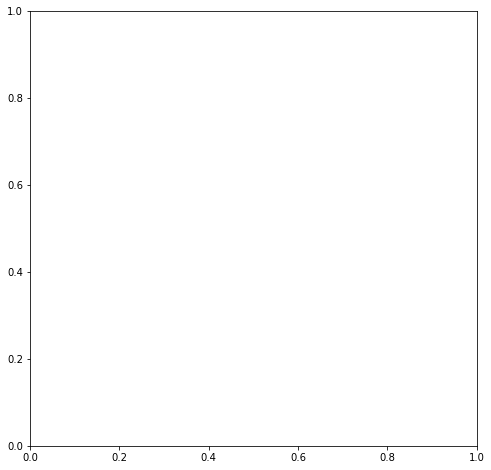

In [120]:
colors=['blue','red']
plt.figure(figsize=(8,8))
plt.title
plt.scatter(dataTrn['max_smv'], dataTrn['min_smv'], c=colors,s=1)
plt.show()